In [1]:
import os
import pandas as pd
import re

_DPI = 600

_ROOT = '../results/default/contrast'
_MODELS = ['octo-base', 'openvla-7b', 'open-pi-zero']
_PATTERNS = ['^by=point_tracking--(alpha)=(\d+\.\d+)--(num_repeats)=(\d+)$', '^by=point_tracking--(alpha)=(\d+\.\d+)$']

def findall_any(patterns, string):
    for pattern in patterns:
        match = re.findall(pattern, string)
        if match:
            return match[0]
    return None

def parse_value(value):
    if re.match(r'^\d+\.\d+$', value):
        return float(value)
    elif value.isdigit():
        return int(value)
    elif value in ['True', 'False']:
        return value == 'True'
    return value

def parse_params(params):
    parsed = {}
    for i in range(0, len(params), 2):
        key = params[i]
        value = parse_value(params[i + 1])
        parsed[key] = value
    return parsed

def find_result_path(dir_):
    for root, dirs, files in os.walk(dir_):
        for file in files:
            if file.endswith('.csv'):
                return os.path.join(root, file)
    return None

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

dfs = []
for model in _MODELS:
    result_dir = os.path.join(_ROOT, model)
    for filename in os.listdir(result_dir):
        params = findall_any(_PATTERNS, filename)
        if params:
            result_path = find_result_path(os.path.join(result_dir, filename))
            if result_path:
                df = pd.read_csv(result_path)
                params = parse_params(params)
                for key, value in params.items():
                    df[key] = value
                df['model'] = model
                dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(3, 1.88))
sns.set_theme(style='whitegrid')

df2 = df[df['task'] == 'average']
df2 = df2[(df2['num_repeats'] == 24) | (df2['num_repeats'].isna())].sort_values('alpha')

ax = brokenaxes(ylims=((0.15, 0.25), (0.63, 0.749)), hspace=.2, despine=False, diag_color='#d2d2d2')

df3 = df2[df2['model'] == 'octo-base']
ax.plot(df3['alpha'], df3['success'], marker='o', linestyle='-', color='#4c72b0', label='Octo')
df3 = df2[df2['model'] == 'openvla-7b']

ax.plot(df3['alpha'], df3['success'], marker='o', linestyle='-', color='#dd8452', label='OpenVLA')
df3 = df2[df2['model'] == 'open-pi-zero']
ax.plot(df3['alpha'], df3['success'], marker='o', linestyle='-', color='#55a868', label='Pi-0')

ax.tick_params(axis='both', which='major', direction='out', length=0, width=2)
ax.axs[0].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.axs[1].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

# ax.legend(loc=(0.0, 0.9), ncol=3, frameon=False, handletextpad=0.2)
ax.legend(loc=(0.01, 0.84), ncol=3, handlelength=1.3, handletextpad=0.2, columnspacing=0.5, facecolor='white', edgecolor='none', framealpha=1.0, borderpad=0.2)

plt.xlabel(r'(a) $\alpha$', labelpad=20)
plt.ylabel('', labelpad=35)
plt.savefig('alpha.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

In [5]:
_PATTERNS = ['^(by)=(\w+)--(alpha)=(\d+\.\d+)--(num_repeats)=(\d+)$', '^(by)=(\w+)--(alpha)=(\d+\.\d+)$']

dfs = []
for model in _MODELS:
    result_dir = os.path.join(_ROOT, model)
    for filename in os.listdir(result_dir):
        params = findall_any(_PATTERNS, filename)
        if params:
            result_path = find_result_path(os.path.join(result_dir, filename))
            if result_path:
                df = pd.read_csv(result_path)
                params = parse_params(params)
                for key, value in params.items():
                    df[key] = value
                df['model'] = model
                dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

df2 = df[df['by'].isin(['grounded_sam_tracking', 'yolo_world_tracking', 'sed_tracking'])]

df2_octo = df2[df2['model'] == 'octo-base']
df2_openvla = df2[df2['model'] == 'openvla-7b']
df2_openpi = df2[df2['model'] == 'open-pi-zero']
df2_octo = df2_octo[df2_octo['alpha'] == 1.0]
df2_openvla = df2_openvla[df2_openvla['alpha'] == 0.8]
df2_openpi = df2_openpi[df2_openpi['alpha'] == 0.2]
df2 = pd.concat([df2_octo, df2_openvla, df2_openpi], ignore_index=True)
df2 = df2[df2['task'] == 'average'].replace({
    'octo-base': 'Octo',
    'openvla-7b': 'OpenVLA',
    'open-pi-zero': 'Pi-0',
    'grounded_sam_tracking': 'GDINO',
    'yolo_world_tracking': 'YOLO World',
    'sed_tracking': 'SED',
})
df2 = df2.sort_values('by', key=lambda x: x.map({
    'GDINO': 0,
    'YOLO World': 1,
    'SED': 2,
}))

plt.figure(figsize=(3, 1.88))
sns.barplot(data=df2, x='model', y='success', hue='by', dodge=True)
plt.hlines(y=[0.156, 0.166, 0.649], xmin=[-0.4, 0.6, 1.6], xmax=[0.4, 1.4, 2.4], color='k', linestyle='--', linewidth=0.9)

plt.legend(loc=(0.01, 0.56), facecolor='white', edgecolor='none', framealpha=1.0, labelspacing=0.1)
plt.tick_params(axis='both', which='major', direction='out', length=0, width=2)

plt.xlabel('(b)')
plt.ylabel('')
plt.savefig('tracking.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

In [6]:
_PATTERNS = ['^(by)=(\w+)--(alpha)=(\d+\.\d+)--(num_repeats)=(\d+)--(inpaint_mode)=(\w+)$', '^(by)=(\w+)--(alpha)=(\d+\.\d+)--(inpaint_mode)=(\w+)$']

dfs = []
for model in _MODELS:
    result_dir = os.path.join(_ROOT, model)
    for filename in os.listdir(result_dir):
        params = findall_any(_PATTERNS, filename)
        if params:
            result_path = find_result_path(os.path.join(result_dir, filename))
            if result_path:
                df = pd.read_csv(result_path)
                params = parse_params(params)
                for key, value in params.items():
                    df[key] = value
                df['model'] = model
                dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

df2 = df[df['inpaint_mode'].isin(['lama', 'ns', 'telea'])]

df2_octo = df2[df2['model'] == 'octo-base']
df2_openvla = df2[df2['model'] == 'openvla-7b']
df2_openpi = df2[df2['model'] == 'open-pi-zero']
df2_octo = df2_octo[df2_octo['alpha'] == 1.0]
df2_openvla = df2_openvla[df2_openvla['alpha'] == 0.8]
df2_openpi = df2_openpi[df2_openpi['alpha'] == 0.2]
df2 = pd.concat([df2_octo, df2_openvla, df2_openpi], ignore_index=True)
df2 = df2[df2['task'] == 'average'].replace({
    'octo-base': 'Octo',
    'openvla-7b': 'OpenVLA',
    'open-pi-zero': 'Pi-0',
    'lama': 'LaMa',
    'ns': 'Navier-Stokes',
    'telea': 'Telea',
})
df2 = df2.sort_values('inpaint_mode', key=lambda x: x.map({
    'LaMa': 0,
    'Telea': 1,
    'Navier-Stokes': 2,
}))

plt.figure(figsize=(3, 1.88))
sns.barplot(data=df2, x='model', y='success', hue='inpaint_mode', dodge=True)
plt.hlines(y=[0.156, 0.166, 0.649], xmin=[-0.4, 0.6, 1.6], xmax=[0.4, 1.4, 2.4], color='k', linestyle='--', linewidth=0.9)

plt.legend(loc=(0.01, 0.56), facecolor='white', edgecolor='none', framealpha=1.0, labelspacing=0.1)
plt.tick_params(axis='both', which='major', direction='out', length=0, width=2)
plt.xlabel('(c)')
plt.ylabel('')
plt.savefig('inpaint.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

In [7]:
fig = plt.figure(figsize=(8.2, 1.88))

plt.subplot(131)
plt.imshow(plt.imread('alpha.png'))
plt.axis('off')

plt.subplot(132)
plt.imshow(plt.imread('tracking.png'))
plt.axis('off')

plt.subplot(133)
plt.imshow(plt.imread('inpaint.png'))
plt.axis('off')

plt.subplots_adjust(wspace=0.0, hspace=0.0)
fig.supylabel('Success Rate', x=0.105, y=0.57, fontsize=9)

plt.savefig('ablation.png', dpi=_DPI, bbox_inches='tight', pad_inches=0)
plt.close()

In [8]:
import numpy as np
import seaborn_image as isns

def read_first_frame(gif_path):
    from PIL import Image
    with Image.open(gif_path) as img:
        img.seek(0)
        img = img.convert('RGB')
        return np.array(img.copy())

images, tasks = [], []
gif_root = 'real_world/pcd_False'
for task in ['pick the ball', 'pick the plug', 'move the can near the apple', 'put the cookies on the towel', 'place the banana in the plate', 'stack the green cube on the blue cube']:
    gif_path = os.path.join(gif_root, task, os.listdir(os.path.join(gif_root, task))[2])
    img = read_first_frame(gif_path)
    images.append(img)
    tasks.append(task)

isns.ImageGrid(images, cbar=False, height=1, col_wrap=1)
plt.savefig('real_world.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

isns.ImageGrid(images, cbar=False, height=3, col_wrap=6)
plt.savefig('real_world_v2.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

In [9]:
df = pd.DataFrame([
    ['Pick Ball', 0.3, 'Baseline'],
    ['Pick Ball', 0.5, '+PCD'],
    ['Pick Plug', 0.1, 'Baseline'],
    ['Pick Plug', 0.2, '+PCD'],
    ['Move Near', 0.1, 'Baseline'],
    ['Move Near', 0.3, '+PCD'],
    ['Cookies Towel', 0.2, 'Baseline'], 
    ['Cookies Towel', 0.3, '+PCD'], 
    ['Banana Plate', 0, 'Baseline'], 
    ['Banana Plate', 0.4, '+PCD'], 
    ['Stack Cube', 0.1, 'Baseline'],
    ['Stack Cube', 0.4, '+PCD'],
    ], columns=['task', 'success', 'model'])

plt.figure(figsize=(3, 6))
sns.barplot(data=df, y='task', x='success', hue='model', dodge=True)
plt.xlabel('Success Rate')
plt.ylabel('')
plt.legend(loc=(0.6, 0.87), frameon=False)
plt.savefig('real_world_bar.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

plt.figure(figsize=(10, 2))
ax = sns.barplot(data=df, x='task', y='success', hue='model', width=0.6, dodge=True)
for i in ax.containers:
    ax.bar_label(i, fmt='{:.1f}')

plt.xlabel('')
plt.ylabel('Success Rate', fontsize=12)
plt.ylim(0, 0.57)
plt.legend(loc=(0.28, 0.75), frameon=False, ncol=2)
plt.text(3.0, 0.466, '(+169%)', color='red')
plt.savefig('real_world_bar_v2.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

In [10]:
import cv2
import seaborn_image as isns

def read_first_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame
    else:
        raise ValueError("Could not read video file")

images, tasks = [], []
gif_root = 'real_world2/pcd_False'
for task in ['pick the ball', 'pick the plug', 'move the can near the apple', 'put the cookies on the towel', 'put the banana in the plate', 'stack the green cube on the blue cube']:
    gif_path = os.path.join(gif_root, task, os.listdir(os.path.join(gif_root, task))[2])
    img = read_first_frame(gif_path)
    images.append(img)
    tasks.append(task)

isns.ImageGrid(images, cbar=False, height=1, col_wrap=1)
plt.savefig('real_world2.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

isns.ImageGrid(images, cbar=False, height=3, col_wrap=6)
plt.savefig('real_world2_v2.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

In [11]:
import pandas as pd

gif_root = 'real_world2'
tasks = ['pick the ball', 'pick the plug', 'move the can near the apple', 'move the can near the watermelon', 'put the cookies on the towel', 'put the banana in the plate', 'stack the green cube on the blue cube']
results = []

for pcd in [False, True]:
    for task in tasks:
        result_dir = os.path.join(gif_root, f'pcd_{pcd}', task)
        for filename in os.listdir(result_dir):
            success, time = filename.split('_')[:2]
            success = True if success == 'True' else False
            time = float(time[:-1]) if success else 0
            model = 'Baseline' if not pcd else '+PCD'
            results.append({
                'model': model,
                'task': task,
                'success': success,
                'time': time,
            })

results_baseline = [result for result in results if result['model'] == 'Baseline']
results_pcd = [result for result in results if result['model'] == '+PCD']
average_success_baseline = sum(result['success'] for result in results_baseline) / len(results_baseline)
average_success_pcd = sum(result['success'] for result in results_pcd) / len(results_pcd)

results_success_baseline = [result for result in results_baseline if result['success']]
results_success_pcd = [result for result in results_pcd if result['success']]
average_time_baseline = sum(result['time'] for result in results_success_baseline) / len(results_success_baseline)
average_time_pcd = sum(result['time'] for result in results_success_pcd) / len(results_success_pcd)
print(f'Baseline: {average_success_baseline:.2f}, {average_time_baseline:.2f}')
print(f'PCD: {average_success_pcd:.2f}, {average_time_pcd:.2f}')

def mean_ignore_zero(values):
    non_zero_values = [v for v in values if v > 0]
    return sum(non_zero_values) / len(non_zero_values) if non_zero_values else 0

df = pd.DataFrame(results).replace({
    'pick the ball': 'Pick Ball',
    'pick the plug': 'Pick Plug',
    'move the can near the apple': 'Move Near',
    'move the can near the watermelon': 'Move Near',
    'put the cookies on the towel': 'Cookies Towel',
    'put the banana in the plate': 'Banana Plate',
    'stack the green cube on the blue cube': 'Stack Cube',
})
df = df.groupby(['model', 'task']).agg({'success': 'mean', 'time': mean_ignore_zero}).reset_index().sort_values('model', ascending=False).sort_values('task', key=lambda x: x.map({
    'Pick Ball': 0,
    'Pick Plug': 1,
    'Move Near': 2,
    'Cookies Towel': 3,
    'Banana Plate': 4,
    'Stack Cube': 5,
}))
# df = pd.concat([df, pd.DataFrame({
#     'model': ['Baseline', '+PCD'],
#     'task': ['Total', 'Total'],
#     'success': [average_success_baseline, average_success_pcd],
#     'time': [average_time_baseline, average_time_pcd],
# })])

plt.figure(figsize=(2, 6))
sns.barplot(data=df, y='task', x='success', hue='model', dodge=True)
plt.xlabel('Success Rate')
plt.ylabel('')
plt.legend(loc=(0.6, 0.87), frameon=False)
plt.savefig('real_world2_bar.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

plt.figure(figsize=(10, 1.5))
ax = sns.barplot(data=df, x='task', y='success', hue='model', width=0.6, dodge=True)
for i in ax.containers:
    ax.bar_label(i, fmt='{:.2f}')

plt.xlabel('')
plt.ylabel('Success Rate', fontsize=12)
plt.ylim(0, 0.57)
plt.legend(loc=(0.30, 0.77), frameon=False, ncol=2)
plt.text(3.12, 0.49, '(+108%)', color='red')

plt.savefig('real_world2_bar_v2.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

plt.figure(figsize=(10, 1.5))
df['time'] = -df['time']
ax = sns.barplot(data=df, x='task', y='time', hue='model', width=0.6, dodge=True)

for idx, container in enumerate(ax.containers):
    if idx == 0:
        ax.bar_label(container, labels=['12', '16', '18', '20', '22', '19'])
    else:
        ax.bar_label(container, labels=['14', '19', '24', '25', '25', '24'])

plt.xlabel('')
plt.ylabel('Time Cost (s)', fontsize=12)
plt.xticks([], [])
plt.yticks([0, -20], ['0', '20'])
plt.ylim(-40, 0)
plt.legend(loc=(0.30, -0.03), frameon=False, ncol=2)
plt.text(3.12, -37.6, '(+24%)', color='green')

plt.savefig('real_world2_cost_bar_v2.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

Baseline: 0.13, 17.20
PCD: 0.27, 21.34


In [12]:
import numpy as np
from PIL import Image

def tile_images(images):
    # resize to same width
    widths = [img.shape[1] for img in images]
    max_width = max(widths)
    for i in range(len(images)):
        if images[i].shape[1] != max_width:
            images[i] = np.array(Image.fromarray(images[i]).resize((max_width, images[i].shape[0] * max_width // images[i].shape[1])))
    # stack images vertically
    tiled_image = np.vstack(images)
    # save the tiled image
    tiled_image_pil = Image.fromarray(tiled_image)
    return tiled_image_pil

image_paths = ['real_world2_bar_v2.png', 'real_world2_v2.png', 'real_world2_cost_bar_v2.png']
images = [np.array(Image.open(img).convert('RGB')) for img in image_paths]

In [13]:
import numpy as np
import seaborn_image as isns

def read_first_frame(gif_path):
    from PIL import Image
    with Image.open(gif_path) as img:
        img.seek(0)
        img = img.convert('RGB')
        return np.array(img.copy())

images, tasks = [], []
gif_root = '../results/motivation/contrast/openvla-7b/by=point_tracking--alpha=0.8'
for task in ['google_robot_pick_coke_can',
             'google_robot_pick_coke_can_drawer_variant', 
             'google_robot_pick_coke_can_light_variant',
             'google_robot_pick_coke_can_dark',
             'google_robot_pick_coke_can_table_paper_variant',
             'google_robot_pick_coke_can_table_stone_variant']:
    gif_path = os.path.join(gif_root, task, [filename for filename in os.listdir(os.path.join(gif_root, task)) if 'episode_0' in filename][0])
    img = read_first_frame(gif_path)
    img = img[:len(img)//2]
    images.append(img)
    tasks.append(task)

isns.ImageGrid(images, cbar=False, height=1, col_wrap=1)
plt.savefig('factor.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

isns.ImageGrid(images, cbar=False, height=3, col_wrap=6)
plt.savefig('factor_v2.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

In [14]:
dfs = []

root = '../results/motivation/baseline/openvla-7b'
result_path = find_result_path(root)
df = pd.read_csv(result_path)
df['model'] = 'Baseline'
dfs.append(df)

root = '../results/motivation/contrast/openvla-7b'
result_path = find_result_path(root)
df = pd.read_csv(result_path)
df['model'] = '+PCD'
dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df = df[~df['task'].isin(['average', 'google_robot_average'])]
# task sort by drawer, light, dark, paper, stone
df = df.sort_values('task', key=lambda x: x.map({
    'google_robot_pick_coke_can': 0,
    'google_robot_pick_coke_can_drawer_variant': 1,
    'google_robot_pick_coke_can_light_variant': 2,
    'google_robot_pick_coke_can_dark': 3,
    'google_robot_pick_coke_can_paper_variant': 4,
    'google_robot_pick_coke_can_stone_variant': 5,
}))

plt.figure(figsize=(10, 4))

df_pcd = df[df['model'] == '+PCD']
df_pcd['success'] -= 0.4
df_pcd['success'] /= 0.4
plt.subplot2grid((10, 1), (0, 0), rowspan=4)
sns.barplot(data=df_pcd, x='task', y='success', color='#dd8452')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([-0.1, 0.0, 0.1], ['-10%', '+PCD (0.4)', '+10%'])
plt.legend().set_visible(False)

df_baseline = df[df['model'] == 'Baseline']
df_baseline['success'] -= 0.25
df_baseline['success'] /= 0.25
plt.subplot2grid((10, 1), (4, 0), rowspan=6)
sns.barplot(data=df_baseline, x='task', y='success', color='#4c72b0')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0, 1, 2, 3, 4], ['Drawer Position', 'Light Position', 'Dark', 'Paper', 'Stone'])
plt.yticks([-0.4, -0.3, -0.2, -0.1, 0.0], ['-40%', '-30%', '-20%', '-10%', 'Baseline (0.25)'])
plt.legend().set_visible(False)

plt.savefig('factor_bar.png')
plt.close()

/tmp/ipykernel_531615/1619248101.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pcd['success'] -= 0.4
/tmp/ipykernel_531615/1619248101.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pcd['success'] /= 0.4
/tmp/ipykernel_531615/1619248101.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)
/tmp/ipykernel_531615/1619248101.py:41: Settin

/tmp/ipykernel_531615/106956955.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pcd['success'] -= 0.4
/tmp/ipykernel_531615/106956955.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_baseline['success'] -= 0.25


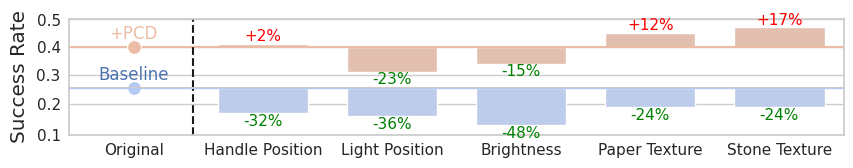

In [66]:
sns.set_theme(style='whitegrid')
sns.set_palette('coolwarm')

fig = plt.figure(figsize=(10, 1.5))
height = 100
shift = 60

df_pcd = df[df['model'] == '+PCD']
df_pcd['success'] -= 0.4
plt.subplot2grid((height, 1), (0, 0), rowspan=shift)
ax = sns.barplot(data=df_pcd, x='task', y='success', color='#ECBCA7', width=0.7)
# sns.scatterplot(data=df_pcd, x='task', y='success', color='#dd8452', s=100, zorder=10)
sns.scatterplot(x=[0], y=[0], color='#ECBCA7', s=100, zorder=10)
sns.scatterplot(x=[0], y=[-0.15], color='#B5CAF3', s=100, zorder=10)
# sns.lineplot(data=df_pcd, x='task', y='success', color='#dd8452', zorder=1)
plt.hlines(0.0, -1, 6, color='#ECBCA7')
plt.hlines(-0.15, -1, 6, color='#ECBCA7', zorder=999)
plt.vlines(0.46, -0.15, 0.1, color='k', linestyle='--')
plt.xlim(-0.5, 5.5)
plt.ylim(-0.15, 0.1)
ax.tick_params(axis='both', pad=0)

plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([-0.1, 0.0, 0.1], ['0.3', '0.4', '0.5'])
plt.text(0, 0.03, '+PCD', fontsize=12, color='#ECBCA7', ha='center')

# add percent text label
for i in range(len(df_pcd)):
    if df_pcd['success'].iloc[i] > 0:
        plt.text(i, df_pcd['success'].iloc[i] + 0.001, f'+{df_pcd["success"].iloc[i] / 0.4:.0%}', ha='center', va='bottom', fontsize=11, color='red')
    elif df_pcd['success'].iloc[i] < 0:
        plt.text(i, df_pcd['success'].iloc[i] - 0.001, f'{df_pcd["success"].iloc[i] / 0.4:.0%}', ha='center', va='top', fontsize=11, color='green')

handles1, labels1 = plt.gca().get_legend_handles_labels()

df_baseline = df[df['model'] == 'Baseline']
df_baseline['success'] -= 0.25
plt.subplot2grid((height, 1), (shift, 0), rowspan=height - shift)
sns.barplot(data=df_baseline, x='task', y='success', color='#B5CAF3', width=0.7)
# sns.scatterplot(data=df_baseline, x='task', y='success', color='#4c72b0', s=100, zorder=999)
ax = sns.scatterplot(x=[0], y=[-0.0], color='#B5CAF3', s=100, zorder=10)
# sns.lineplot(data=df_baseline, x='task', y='success', color='#4c72b0', zorder=1)
plt.hlines(0.0, -1, 6, color='#B5CAF3', zorder=999)
plt.vlines(0.46, -0.15, 0.0, color='k', linestyle='--')
plt.xlim(-0.5, 5.5)
plt.ylim(-0.15, 0.0)

plt.xlabel('')
plt.ylabel('')
ax.tick_params(axis='both', pad=0)

plt.xticks([0, 1, 2, 3, 4, 5], ['Original', 'Handle Position', 'Light Position', 'Brightness', 'Paper Texture', 'Stone Texture'])
plt.yticks([-0.15, -0.05, 0.00], ['0.1', '0.2', ''])
# plt.legend().set_visible(False)
plt.text(0, 0.03, 'Baseline', fontsize=12, color='#4c72b0', ha='center')

# add percent text label
for i in range(len(df_baseline)):
    if df_baseline['success'].iloc[i] > 0:
        plt.text(i, df_baseline['success'].iloc[i] + 0.001, f'+{df_baseline["success"].iloc[i] / 0.25:.0%}', ha='center', va='bottom', fontsize=11, color='red')
    elif df_baseline['success'].iloc[i] < 0:
        plt.text(i, df_baseline['success'].iloc[i] - 0.001, f'{df_baseline["success"].iloc[i] / 0.25:.0%}', ha='center', va='top', fontsize=11, color='green')

# subplot no margin
plt.subplots_adjust(hspace=0.0, wspace=0.0)
fig.supylabel('Success Rate', x=0.066)

plt.savefig('factor_bar_v2.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
# plt.close()

In [21]:
import cv2
import matplotlib.pyplot as plt
import seaborn_image as isns

def read_first_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame
    else:
        raise ValueError("Could not read video file")

images, tasks = [], []
gif_root = 'pcd_real_world'
for task in ['put the banana in the plate']:
    gif_path = os.listdir(os.path.join(gif_root, 'pcd_True', task))[0]
    gif_path = os.path.join(gif_root, 'pcd_True', task, gif_path)
    img = read_first_frame(gif_path)
    images.append(img)
    tasks.append(task)

gif_root = 'pcd_real_world_unseen'
for task in ['object', 'background', 'darkness', 'lego', 'yellow']:
    task = f'{task}_pcd_True'
    gif_paths = os.listdir(os.path.join(gif_root, task))
    gif_paths = [path for path in gif_paths if 'front' in path]
    
    if task == 'yellow_pcd_True':
        gif_paths = ['put the banana in the plate_step101_time26.988736152648926_success_front_fe0bf256-0df5-407a-9e8f-c97f5d0697a1.mp4']
    
    gif_path = gif_paths[0]
    gif_path = os.path.join(gif_root, task, gif_path)
    img = read_first_frame(gif_path)
    images.append(img)
    tasks.append(task)

isns.ImageGrid(images, cbar=False, height=1, col_wrap=1)
plt.savefig('real_world_unseen.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

isns.ImageGrid(images, cbar=False, height=3, col_wrap=6)
plt.savefig('real_world_unseen_v2.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
plt.close()

pcd_real_world/pcd_True/put the banana in the plate/True_24.17s_e6547fcb-5b65-4350-a733-99664d67e072.avi


In [24]:
import seaborn as sns

results = [
    {
        'model': 'Baseline',
        'task': 'Original',
        'success': 0.2,
    },
    {
        'model': '+PCD',
        'task': 'Original',
        'success': 0.35,
    }
]

data_root = 'pcd_real_world_unseen'
for task in ['object', 'background', 'darkness', 'lego', 'yellow']:
    for pcd in [False, True]:
        subdir = f'{task}_pcd_{pcd}'
        result_dir = os.path.join(data_root, subdir)
        for filename in os.listdir(result_dir):
            instruction, step, time, success, view, uid = filename.split('_')
            success = success == 'success'
            results.append({
                'model': '+PCD' if pcd else 'Baseline',
                'task': task,
                'success': success,
            })

df = pd.DataFrame(results).groupby(['model', 'task']).agg({'success': 'mean'}).reset_index().sort_values('model', ascending=False).sort_values('task', key=lambda x: x.map({
    'Original': 0,
    'object': 1,
    'background': 2,
    'darkness': 3,
    'lego': 4,
    'yellow': 5,
})).replace({
    'object': 'Distractor',
    'background': 'Layout',
    'darkness': 'Brightness',
    'lego': 'Table Texture',
    'yellow': 'Table Texture2',
})

print(df)

plt.figure(figsize=(10, 4))

df_pcd = df[df['model'] == '+PCD']
df_pcd['success'] -= 0.35
df_pcd['success'] /= 0.35
plt.subplot2grid((10, 1), (0, 0), rowspan=4)
sns.barplot(data=df_pcd, x='task', y='success', color='#dd8452')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
# plt.yticks([-0.1, 0.0, 0.1], ['-10%', '+PCD (0.4)', '+10%'])
plt.legend().set_visible(False)

df_baseline = df[df['model'] == 'Baseline']
df_baseline['success'] -= 0.2
df_baseline['success'] /= 0.2
plt.subplot2grid((10, 1), (4, 0), rowspan=6)
sns.barplot(data=df_baseline, x='task', y='success', color='#4c72b0')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0, 1, 2, 3, 4], ['Object', 'Background', 'Darkness', 'Lego', 'Yellow'])
# plt.yticks([-0.4, -0.3, -0.2, -0.1, 0.0], ['-40%', '-30%', '-20%', '-10%', 'Baseline (0.25)'])
plt.legend().set_visible(False)

plt.savefig('factor_bar_unseen.png')
plt.close()

/tmp/ipykernel_3391489/3603640219.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  })).replace({
/tmp/ipykernel_3391489/3603640219.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pcd['success'] -= 0.35
/tmp/ipykernel_3391489/3603640219.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

       model            task  success
6   Baseline        Original     0.20
0       +PCD        Original     0.35
10  Baseline      Distractor     0.05
4       +PCD      Distractor     0.45
7   Baseline          Layout     0.15
1       +PCD          Layout     0.40
8   Baseline      Brightness     0.05
2       +PCD      Brightness     0.45
9   Baseline   Table Texture     0.10
3       +PCD   Table Texture     0.25
11  Baseline  Table Texture2     0.10
5       +PCD  Table Texture2     0.35


/tmp/ipykernel_3391489/2272218572.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pcd['success'] -= 0.35
/tmp/ipykernel_3391489/2272218572.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_baseline['success'] -= 0.2


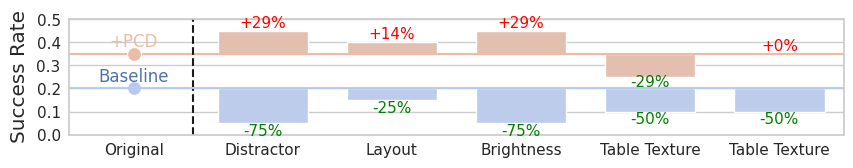

In [29]:
sns.set_theme(style='whitegrid')
sns.set_palette('coolwarm')

fig = plt.figure(figsize=(10, 1.5))
height = 100
shift = 60

df_pcd = df[df['model'] == '+PCD']
df_pcd['success'] -= 0.35
plt.subplot2grid((height, 1), (0, 0), rowspan=shift)
ax = sns.barplot(data=df_pcd, x='task', y='success', color='#ECBCA7', width=0.7)
# sns.scatterplot(data=df_pcd, x='task', y='success', color='#dd8452', s=100, zorder=10)
sns.scatterplot(x=[0], y=[0], color='#ECBCA7', s=100, zorder=10)
sns.scatterplot(x=[0], y=[-0.15], color='#B5CAF3', s=100, zorder=10)
# sns.lineplot(data=df_pcd, x='task', y='success', color='#dd8452', zorder=1)
plt.hlines(0.0, -1, 6, color='#ECBCA7')
plt.hlines(-0.15, -1, 6, color='#ECBCA7', zorder=999)
plt.vlines(0.46, -0.15, 0.15, color='k', linestyle='--')
plt.xlim(-0.5, 5.5)
plt.ylim(-0.15, 0.15)
ax.tick_params(axis='both', pad=0)

plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([-0.05, 0.05, 0.15], ['0.3', '0.4', '0.5'])
plt.text(0, 0.03, '+PCD', fontsize=12, color='#ECBCA7', ha='center')

# add percent text label
for i in range(len(df_pcd)):
    if i == 0:
        continue
    if df_pcd['success'].iloc[i] >= 0:
        plt.text(i, df_pcd['success'].iloc[i] + 0.001, f'+{df_pcd["success"].iloc[i] / 0.35:.0%}', ha='center', va='bottom', fontsize=11, color='red')
    elif df_pcd['success'].iloc[i] < 0:
        plt.text(i, df_pcd['success'].iloc[i] + 0.01, f'{df_pcd["success"].iloc[i] / 0.35:.0%}', ha='center', va='top', fontsize=11, color='green')

handles1, labels1 = plt.gca().get_legend_handles_labels()

df_baseline = df[df['model'] == 'Baseline']
df_baseline['success'] -= 0.2
plt.subplot2grid((height, 1), (shift, 0), rowspan=height - shift)
sns.barplot(data=df_baseline, x='task', y='success', color='#B5CAF3', width=0.7)
# sns.scatterplot(data=df_baseline, x='task', y='success', color='#4c72b0', s=100, zorder=999)
ax = sns.scatterplot(x=[0], y=[-0.0], color='#B5CAF3', s=100, zorder=10)
# sns.lineplot(data=df_baseline, x='task', y='success', color='#4c72b0', zorder=1)
plt.hlines(0.0, -1, 6, color='#B5CAF3', zorder=999)
plt.vlines(0.46, -0.2, 0.0, color='k', linestyle='--')
plt.xlim(-0.5, 5.5)
plt.ylim(-0.15, 0.0)

plt.xlabel('')
plt.ylabel('')
ax.tick_params(axis='both', pad=0)

plt.xticks([0, 1, 2, 3, 4, 5], ['Original', 'Distractor', 'Layout', 'Brightness', 'Table Texture', 'Table Texture'])
plt.yticks([-0.2, -0.1, 0.0], ['0.0', '0.1', '0.2'])
# plt.legend().set_visible(False)
plt.text(0, 0.03, 'Baseline', fontsize=12, color='#4c72b0', ha='center')

# add percent text label
for i in range(len(df_baseline)):
    if i == 0:
        continue
    if df_baseline['success'].iloc[i] > 0:
        plt.text(i, df_baseline['success'].iloc[i] + 0.001, f'+{df_baseline["success"].iloc[i] / 0.2:.0%}', ha='center', va='bottom', fontsize=11, color='red')
    elif df_baseline['success'].iloc[i] < 0:
        plt.text(i, df_baseline['success'].iloc[i] - 0.001, f'{df_baseline["success"].iloc[i] / 0.2:.0%}', ha='center', va='top', fontsize=11, color='green')

# subplot no margin
plt.subplots_adjust(hspace=0.0, wspace=0.0)
fig.supylabel('Success Rate', x=0.066)

plt.savefig('factor_bar_unseen_v2.png', dpi=_DPI, bbox_inches='tight', pad_inches=0.01)
# plt.close()